The Fractional Friedmann Equation:
 
$$ {}^{C}D^{\alpha}_{t}a(t) = \tau_{0}^{\alpha-1} H_{0} \left[\sum_{i}\Omega_{i}\left(\frac{a_{0}}{a(t)}\right)^{3(1+w_{i})}\right]^{1/2} a(t) $$
 
where:
- $0 < \alpha \leq 1$ is the fractional order
- $\tau_0$ is a characteristic time scale (typically $1/H_0$)
- $\Omega_i$ are density parameters for different components (matter, dark energy, radiation)
- $w_i$ are equation of state parameters
Gaussian Initial Conditions
$$ a(t) = a_0 \exp\left(-\frac{(t-t_0)^2}{2\sigma^2}\right) $$


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
import warnings
warnings.filterwarnings('ignore')

# For interactive plots in Jupyter
%matplotlib inline

# Set style for better looking plots
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['font.size'] = 12

In [6]:
def solve_fractional_corrected(alpha=1.0, H0=1.0, Omega_m=0.315, Omega_r=9.2e-5,
                              a_start=1e-6, a_end=1.0,
                              min_dt=1e-12, max_dt=1e-4, safety=0.1):

    # Initialize
    t_list = [0.0]
    a_list = [a_start]
    
    t = 0.0
    a = a_start
    Omega_de = 0 #1.0 - Omega_m - Omega_r  
    
    iteration = 0
    max_iterations = 10000
    
    while a < a_end and iteration < max_iterations:
        # Adaptive time step based on Hubble rate
        H = H0 * np.sqrt(Omega_m * a**(-3) + Omega_r * a**(-4) + Omega_de)
        dt = safety / H if H > 0 else min_dt
        dt = np.clip(dt, min_dt, max_dt)
        
        n = len(t_list) - 1  # Current index
        

        gamma_factor = 1.0 / gamma(alpha + 1)
        sum_term = 0.0
        
        for j in range(n + 1):
            weight = gamma_factor * ((n + 1 - j)**alpha - (n - j)**alpha)
            a_j = a_list[j]
            H_j = H0 * np.sqrt(Omega_m * a_j**(-3) + Omega_r * a_j**(-4) + Omega_de)
            f_aj = a_j * H_j  # f(a) = a * H(a)
            sum_term += weight * f_aj
        
        
        a_new = a_start + (dt**alpha) * sum_term
        
        # Update
        t += dt
        a = a_new
        
        t_list.append(t)
        a_list.append(a)
        
        iteration += 1
        
        # Early termination if growing too slowly
        if iteration > 100 and a < 1e-5:
            print(f"Warning: Slow growth after {iteration} iterations (a={a:.2e})")
            break
    
    # Convert to arrays
    t_array = np.array(t_list)
    a_array = np.array(a_list)

    
    return t_array, a_array

In [7]:
t_num, a_num = solve_fractional_corrected(
    alpha=1.0,
    H0=1,
    Omega_m=0.315,
    Omega_r=0,
    a_start=1e-6,
    a_end=1,
    min_dt=1e-5,
    max_dt=1e-4,
    safety=0.01
)

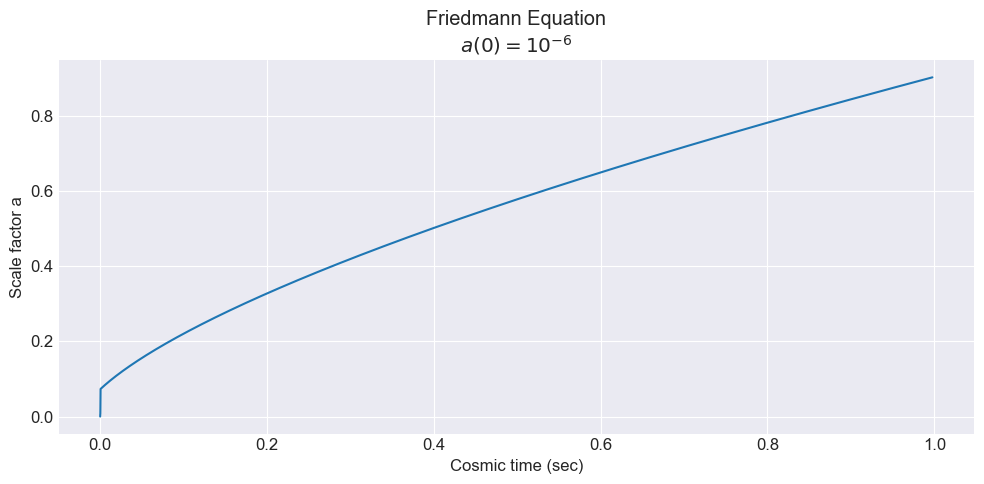

In [8]:
plt.plot(t_num,a_num)
plt.ylabel(r"Scale factor a")
plt.xlabel(r"Cosmic time (sec)")
plt.title("Friedmann Equation\n$ a(0)=10^{-6}$")
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
# ============================================================================
# ADAPTIVE TIME STEPPING BASED ON STABILITY ANALYSIS
# ============================================================================
from numba import njit, float64, int64
import math
@njit(cache=True, fastmath=True)
def compute_hubble(a, H0, Omega_m, Omega_r, Omega_de):
    """Compute Hubble parameter H(a) = H0 * sqrt(Ω_r a⁻⁴ + Ω_m a⁻³ + Ω_de)"""
    a_inv = 1.0 / a
    a_inv2 = a_inv * a_inv
    a_inv3 = a_inv2 * a_inv
    a_inv4 = a_inv3 * a_inv
    
    rad_term = Omega_r * a_inv4
    mat_term = Omega_m * a_inv3
    de_term = Omega_de
    
    return H0 * np.sqrt(rad_term + mat_term + de_term)

@njit(cache=True, fastmath=True)
def compute_f(a, H0, Omega_m, Omega_r, Omega_de):
    """Compute f(a) = H(a) * a"""
    return compute_hubble(a, H0, Omega_m, Omega_r, Omega_de) * a

@njit(cache=True, fastmath=True)
def compute_gamma_ratio(alpha):
    gamma_val = math.gamma(alpha + 1.0)
    gamma_inv = 1.0 / gamma_val
    
    return gamma_val, gamma_inv

@njit(cache=True, fastmath=True)
def compute_adaptive_time_step(a, alpha, H0, Omega_m, Omega_r, Omega_de,
                               safety=0.1, min_dt=1e-20, max_dt=1.0):
    """
    Compute adaptive time step based on stability analysis:
    Δt = safety × [Γ(α+1) / H(a)]^{1/α}
    
    From paper: Δt ≲ [Γ(α+1) / H(a)]^{1/α}
    """
    
    # Get current Hubble parameter
    H = compute_hubble(a, H0, Omega_m, Omega_r, Omega_de)
    
    if H <= 1e-100:  # Avoid division by zero
        return max_dt
    
    # Get Γ(α+1)
    gamma_val, _ = compute_gamma_ratio(alpha)
    
    # Special case: α = 1
    if alpha == 1.0:
        dt = safety / H
    
    # Special case: α = 0.5 (common in your work)
    elif alpha == 0.5:
        ratio = gamma_val / H
        dt = safety * ratio * ratio  # (ratio)² since 1/α = 2
    
    # General case
    else:
        ratio = gamma_val / H
        if ratio > 0:
            dt = safety * (ratio ** (1.0 / alpha))
        else:
            dt = min_dt
    
    # Era-specific adjustments
    if a < 1e-4:
        # Radiation era: extra conservative
        dt *= 0.3
    elif a < 0.01:
        # Early matter era
        dt *= 0.7
    elif a > 0.5:
        # Dark energy era: can be more aggressive
        dt *= 1.5
    
    # Apply absolute bounds
    if dt < min_dt:
        return min_dt
    elif dt > max_dt:
        return max_dt
    else:
        return dt

In [16]:
def solve_fractional_adaptive(alpha=1, H0=1.0, Omega_m=0.315, Omega_r=9.2e-5,
                             a_start=1e-6, a_end=1.0):

    # Initialize lists
    t_list = [0.0]
    a_list = [a_start]
    
    t = 0.0
    a = a_start
    Omega_de = 1.0 - Omega_m - Omega_r
    
    iteration = 0
    max_iterations = 10000
    
    while a < a_end and iteration < max_iterations: 
        dt = compute_adaptive_time_step(a,alpha,H0,Omega_m,Omega_r,Omega_de)
                
        n = len(t_list) - 1  # Current index (0-based)
        
        # Precompute gamma factor
        gamma_factor = 1.0 / gamma(alpha + 1)
        
        # Compute sum: Σ_{j=0}^n b_{j,n+1} f(a_j)
        sum_term = 0.0
        for j in range(n + 1):
            # Weight: b_{j,n+1} = 1/Γ(α+1) * [(n+1-j)^α - (n-j)^α]
            weight = gamma_factor * ((n + 1 - j)**alpha - (n - j)**alpha)
            
            # f(a_j) = H0 * a_j * sqrt(...)
            a_j = a_list[j]
            f_aj = H0 * a_j * np.sqrt(Omega_m * a_j**(-3) + Omega_r * a_j**(-4) + Omega_de)
            
            sum_term += weight * f_aj
        
        # Update: a_{n+1} = a_0 + Δt^α * sum_term
        a_new = a_start + (dt**alpha) * sum_term
        
        # Ensure positivity
        a_new = max(a_new, 1e-20)
        
        # Update
        t += dt
        a = a_new
        
        t_list.append(t)
        a_list.append(a)
        
        iteration += 1
        
    
    # Convert to arrays
    t_array = np.array(t_list)
    a_array = np.array(a_list)
    
    # Find present epoch
    if np.any(a_array >= 1.0):
        idx_present = np.argmax(a_array >= 1.0)
        t_present = t_array[idx_present]
    else:
        idx = np.argmin(np.abs(a_array - 1.0))
        t_present = t_array[idx]
    
    return t_array, a_array, t_present


In [17]:
t_frac, a_frac, t_present_frac = solve_fractional_adaptive(alpha=1.0,H0=1.0,Omega_m=0.315,Omega_r=0.0,
    a_start=1e-6,a_end=1.0)

In [18]:
a_frac.shape

(30,)

In [28]:
a_frac = a_frac[:29]

In [32]:
a_frac

array([1.00000000e-06, 1.03000000e-06, 1.06226007e-06, 1.09707568e-06,
       1.13479934e-06, 1.17585549e-06, 1.22076043e-06, 1.27014921e-06,
       1.32481269e-06, 1.38574956e-06, 1.45424054e-06, 1.53195691e-06,
       1.62112299e-06, 1.72476606e-06, 1.84711296e-06, 1.99424178e-06,
       2.17519618e-06, 2.40398067e-06, 2.70332966e-06, 3.11229089e-06,
       3.70267756e-06, 4.61817755e-06, 6.17844593e-06, 9.19867148e-06,
       1.61699918e-05, 3.68410392e-05, 1.25362830e-04, 1.83124847e-03,
       1.02311983e-01])

In [31]:
t_frac

array([0.00000000e+00, 5.34522484e-11, 1.09327799e-10, 1.67848870e-10,
       2.29270433e-10, 2.93887105e-10, 3.62041976e-10, 4.34138055e-10,
       5.10653320e-10, 5.92160844e-10, 6.79356149e-10, 7.73095156e-10,
       8.74447968e-10, 9.84777030e-10, 1.10585393e-09, 1.24003960e-09,
       1.39057294e-09, 1.56205300e-09, 1.76128653e-09, 1.99886906e-09,
       2.29235429e-09, 2.67319189e-09, 3.20367543e-09, 4.02456522e-09,
       5.51582615e-09, 8.99143326e-09, 2.09440718e-08, 1.96007708e-07,
       9.96981274e-06, 5.83407671e-03])

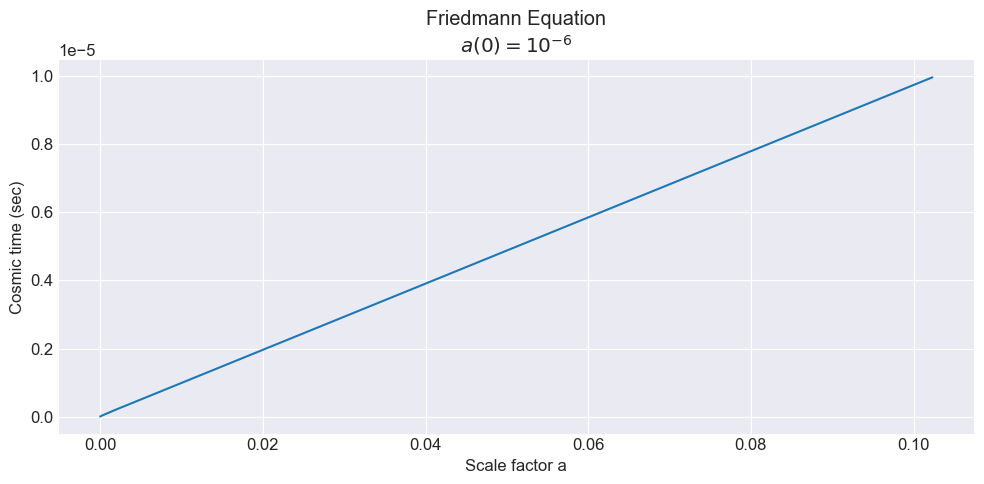

In [30]:
plt.plot(a_frac,t_frac[:29])
plt.xlabel(r"Scale factor a")
plt.ylabel(r"Cosmic time (sec)")
plt.title("Friedmann Equation\n$ a(0)=10^{-6}$")
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
# Convert to physical time (s)
H0_physical = 2.19e-18  # s⁻¹
seconds_per_year = 365.25 * 24 * 3600
seconds_per_Gyr = seconds_per_year * 1e9

# Time from Big Bang in s
t_s = t_frac / H0_physical

In [7]:
y_ticks = [1e1,1e3,1e5,1e7,1e9,1e11,1e13,1e15,1e17]

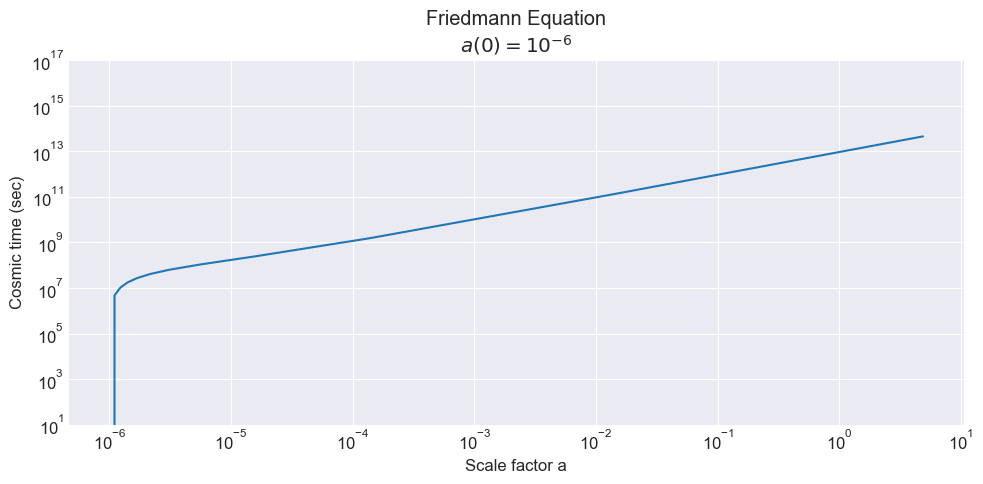

In [8]:
plt.loglog(a_frac,t_s)
plt.xlabel(r"Scale factor a")
plt.ylabel(r"Cosmic time (sec)")
plt.yticks(y_ticks)
plt.title("Friedmann Equation\n$ a(0)=10^{-6}$")
plt.grid(True)
plt.tight_layout()
plt.show()

In [4]:
a_frac[-2]

0.014048857667376716

In [5]:
t_frac[-2]

2.9177683065453865e-07

In [25]:
t_frac.shape

(12,)